In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder


In [57]:
class AnimalModule(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.f1 = nn.Linear(7 * 7 * 20, 100)
        self.out_layer = nn.Linear(100, out_)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, 7 * 7 * 20)
        x = F.relu(self.f1(x))
        x = self.out_layer(x)
        return x


In [58]:
def make_weights(labels, nclasses):
    labels = np.array(labels)
    weight_list = []

    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count
        weights = [weight] * count
        weight_list += weights

    return weight_list


In [59]:
preprocessing = transforms.Compose(
    [
        transforms.Resize((50, 50)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]
)


In [60]:
train_root = "../../data/animals/train"
valid_root = "../../data/animals/val"
trainDS = ImageFolder(train_root, transform=preprocessing)
validDS = ImageFolder(valid_root, transform=preprocessing)


In [61]:
train_weights = make_weights(trainDS.targets, len(trainDS.classes))
train_weights = torch.DoubleTensor(train_weights)
valid_weights = make_weights(validDS.targets, len(validDS.classes))
valid_weights = torch.DoubleTensor(valid_weights)


In [62]:
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
valid_sampler = WeightedRandomSampler(valid_weights, len(valid_weights))


In [63]:
batch_size = 32
trainDL = DataLoader(
    trainDS, batch_size=batch_size, sampler=train_sampler, drop_last=True
)
validDL = DataLoader(
    validDS, batch_size=batch_size, sampler=valid_sampler, drop_last=True
)


In [64]:
for image, label in trainDL:
    print("image:", image.size(), "type:", image.type())
    print("label:", label.size(), "type:", label.type())
    break


image: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
label: torch.Size([32]) type: torch.LongTensor


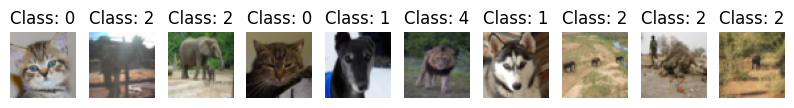

In [65]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(image[i], (1, 2, 0)))
    plt.title("Class: " + str(label[i].item()))


In [66]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE :", DEVICE)


DEVICE : cpu


In [67]:
EPOCHS = 50
IN, OUT = 3, len(trainDS.classes)
MODEL = AnimalModule(IN, OUT).to(DEVICE)
OPTIMIZER = optim.Adam(MODEL.parameters())
LOSS_FN = nn.CrossEntropyLoss()

print(MODEL)


AnimalModule(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (f1): Linear(in_features=980, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=5, bias=True)
)


In [68]:
def learning(epoch, model, loader, optimizer, mode="train", log_interval=200):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode:", mode)

    loss_value = 0
    correct = 0
    with torch.set_grad_enabled(is_train):
        for batch_idx, (image, label) in enumerate(loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            loss = LOSS_FN(output, label)
            loss_value += loss.item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if batch_idx % log_interval == 0:
                    print(
                        f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}"
                    )

    loss_value /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    return loss_value, accuracy


In [69]:
pre_test_loss = 100
count = 0
for epoch in range(1, EPOCHS + 1):

    learning(epoch, MODEL, trainDL, OPTIMIZER, mode="train", log_interval=100)
    test_loss, test_accuracy = learning(epoch, MODEL, validDL, OPTIMIZER, mode="test")

    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )

    if pre_test_loss > test_loss:
        pre_test_loss = test_loss
        count = 0
    else:
        count += 1
        if count == 5:
            break


Train Epoch: 1 [0]	Train Loss: 1.598531
Train Epoch: 1 [100]	Train Loss: 1.355849
Train Epoch: 1 [200]	Train Loss: 1.145568
Train Epoch: 1 [300]	Train Loss: 0.966141
Train Epoch: 1 [400]	Train Loss: 0.863168

[EPOCH: 1], 	Test Loss: 0.0267, 	Test Accuracy: 63.26 % 

Train Epoch: 2 [0]	Train Loss: 1.014840
Train Epoch: 2 [100]	Train Loss: 1.107362
Train Epoch: 2 [200]	Train Loss: 0.771895
Train Epoch: 2 [300]	Train Loss: 0.562684
Train Epoch: 2 [400]	Train Loss: 0.790613

[EPOCH: 2], 	Test Loss: 0.0220, 	Test Accuracy: 69.74 % 

Train Epoch: 3 [0]	Train Loss: 0.504565
Train Epoch: 3 [100]	Train Loss: 0.495152
Train Epoch: 3 [200]	Train Loss: 0.714747
Train Epoch: 3 [300]	Train Loss: 0.419632
Train Epoch: 3 [400]	Train Loss: 0.761310

[EPOCH: 3], 	Test Loss: 0.0224, 	Test Accuracy: 69.81 % 

Train Epoch: 4 [0]	Train Loss: 0.633185
Train Epoch: 4 [100]	Train Loss: 0.917945
Train Epoch: 4 [200]	Train Loss: 0.533243
Train Epoch: 4 [300]	Train Loss: 0.485350
Train Epoch: 4 [400]	Train Loss: 